# Chatbot with Collection Schema

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

## Defining a Collection Schema

In [2]:
from pydantic import BaseModel, Field
from typing import List

class Memory(BaseModel):
    content: str = Field('The main content of the memory. For example: "User expressed interest in reading books"')

class MemoryCollection(BaseModel):
    memories: List[Memory] = Field('A list of Memories about the user')

### Using `with_structured_output`

In [8]:
from langchain_core.messages import SystemMessage, HumanMessage

structured_model = model.with_structured_output(MemoryCollection)

# System Prompt
system_message = """You are a helpful assistant whose task is to store details about the user in the given format"""
human_message = "Hi! My name is Manan. I like to read books."
response = structured_model.invoke([SystemMessage(content=system_message),HumanMessage(content=human_message)])
response

MemoryCollection(memories=[Memory(content="User's name is Manan."), Memory(content='Manan likes to read books.')])

In [15]:
for r in response.memories:
    print(r.model_dump())

{'content': "User's name is Manan."}
{'content': 'Manan likes to read books.'}


### Save all the memories to the store

In [17]:
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

user_id = "1"
namespace_for_memory = (user_id,'memories')

for i, memory in enumerate(response.memories):
    key = f"memory_{i}"
    value = memory.model_dump()
    # Put the memory in the store 
    in_memory_store.put(namespace_for_memory, key, value)

In [21]:
for memory in in_memory_store.search(namespace_for_memory):
    print("-"*50)
    print(memory.dict())

--------------------------------------------------
{'namespace': ['1', 'memories'], 'key': 'memory_0', 'value': {'content': "User's name is Manan."}, 'created_at': '2025-06-29T20:35:58.911828+00:00', 'updated_at': '2025-06-29T20:35:58.911828+00:00', 'score': None}
--------------------------------------------------
{'namespace': ['1', 'memories'], 'key': 'memory_1', 'value': {'content': 'Manan likes to read books.'}, 'created_at': '2025-06-29T20:35:58.911828+00:00', 'updated_at': '2025-06-29T20:35:58.911828+00:00', 'score': None}


## Updating Collection Schema
- Problems: We want to be able to add as well as modify existing memories
- Solution: Trustcall

* We provide the schema for each memory: `Memory`
* We can supply `enable_inserts = True` to allow the extractor to insert new memories to the collection

In [4]:
os.environ['LANGSMITH_TRACING'] = 'false'
from trustcall import create_extractor

trustcall_extractor = create_extractor(model,
                                       tools = [Memory],
                                       tool_choice='Memory',
                                       enable_inserts=True)

In [5]:
print("LangSmith tracing is", "on" if os.environ.get("LANGSMITH_TRACING", "").lower() == "true" else "off")

LangSmith tracing is off


In [12]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Manan."), 
                AIMessage(content="Nice to meet you, Manan."), 
                HumanMessage(content="I have finished more than 80 percent of the langgraph course!")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fvATKGZGh8vsPjwGGK6Oobh7', 'function': {'arguments': '{"content":"Manan has completed more than 80 percent of the langgraph course."}', 'name': 'Memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 116, 'total_tokens': 135, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'stop', 'logprobs': None}, id='run-0b7f8693-4f6a-463f-8991-65a297b60780-0', tool_calls=[{'name': 'Memory', 'args': {'content': 'Manan has completed more than 80 percent of the langgraph course.'}, 'id': 'call_fvATKGZGh8vsPjwGGK6Oobh7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 116, 'output_tokens': 19, 'tota

In [15]:
result['messages'][0].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_fvATKGZGh8vsPjwGGK6Oobh7)
 Call ID: call_fvATKGZGh8vsPjwGGK6Oobh7
  Args:
    content: Manan has completed more than 80 percent of the langgraph course.


In [16]:
result['responses']

[Memory(content='Manan has completed more than 80 percent of the langgraph course.')]

In [17]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you enjoy that?"), 
                        HumanMessage(content="Yes! I built a working Agentic RAG flow using Langgraph. Made good projects while learning itself!"),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I am planning to learn Ambient Agents after this!"),]

# Update the instruction
system_message = "Update existing memories and create new ones based on the following conversation"

# Providing the existing memories with ID, key (tool name) and value
tool_name = 'Memory'
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result['responses'])] if result['responses'] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Manan has completed more than 80 percent of the langgraph course.'})]

In [18]:
# Invoke the extractor with updated_conversation and existing_memories
result = trustcall_extractor.invoke({'messages':updated_conversation, 'existing': existing_memories})
result

{'messages': [AIMessage(content='', additional_kwargs={'updated_docs': {'call_k5XW1YfsyGYRAmiVZNw929LR': '0'}}, id='0383e2bf-5c93-4f16-81a8-9a88b2a2f1ff', tool_calls=[{'name': 'Memory', 'args': {'content': 'Manan has completed more than 80 percent of the Langgraph course, enjoyed building a working Agentic RAG flow, made good projects while learning, and is planning to learn about Ambient Agents next.'}, 'id': 'call_k5XW1YfsyGYRAmiVZNw929LR', 'type': 'tool_call'}])],
 'responses': [Memory(content='Manan has completed more than 80 percent of the Langgraph course, enjoyed building a working Agentic RAG flow, made good projects while learning, and is planning to learn about Ambient Agents next.')],
 'response_metadata': [{'id': 'call_k5XW1YfsyGYRAmiVZNw929LR',
   'json_doc_id': '0'}],
 'attempts': 1}

In [21]:
result['messages'][0].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_k5XW1YfsyGYRAmiVZNw929LR)
 Call ID: call_k5XW1YfsyGYRAmiVZNw929LR
  Args:
    content: Manan has completed more than 80 percent of the Langgraph course, enjoyed building a working Agentic RAG flow, made good projects while learning, and is planning to learn about Ambient Agents next.


In [24]:
result['response_metadata']
# It contains the json_doc_id which it is planning to edit! -> Editing an existing memory

[{'id': 'call_k5XW1YfsyGYRAmiVZNw929LR', 'json_doc_id': '0'}]

In [25]:
result['responses']

[Memory(content='Manan has completed more than 80 percent of the Langgraph course, enjoyed building a working Agentic RAG flow, made good projects while learning, and is planning to learn about Ambient Agents next.')]

## Chatbot with Collection Schema Updating

In [32]:
memory = Memory(content="The user's name is Manan")
memory.content

"The user's name is Manan"

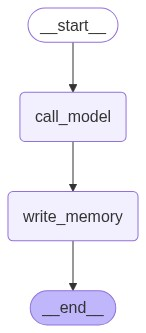

In [38]:
from IPython.display import display, Image
from langgraph.graph import START,END,StateGraph
from langgraph.graph.message import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore, BaseStore
from langchain_core.runnables import RunnableConfig
from uuid import uuid4

# Define the Collection Schema
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: 'The user likes to read books and code!'")

# Trustcall create_extractor
trustcall_extractor = create_extractor(model,
                                       tools = [Memory],
                                       tool_choice='Memory',
                                       enable_inserts=True)

# Define the first node that is a simple chatbot responding to user based on the memory 
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 
You have a long term memory which keeps track of information you learn about the user over time.
Current Memory (may include updated memories from this conversation): 
{memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load the memory and chat with the user"""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Based on the memory structure, format it to make it prompt friendly
    info = "\n".join(f"-{mem.value['content']}" for mem in memories)
    system_message = MODEL_SYSTEM_MESSAGE.format(memory = info)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_message)]+state["messages"])

    return {"messages": response}

# Node 2 to update the memory based on updated_conversation
# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 
Use the provided tools to retain any necessary memories about the user. 
Use parallel tool calling to handle updates and insertions simultaneously:"""

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    existing_items = store.search(namespace)

    # Existing memories must be in the form: ID, key(Tool Name), value
    tool_name = 'Memory'
    existing_memories = [(existing_item.key, tool_name, existing_item.value) for existing_item in existing_items] if existing_items else None

    result = trustcall_extractor.invoke({'messages': [SystemMessage(content=system_message)] + state['messages'],
                                'existing': existing_memories})
    
    # Save the memories to the store
    for r, rmeta in zip(result['responses'], result['response_metadata']):
        store.put(namespace,
                  rmeta.get('json_doc_id',uuid4()),
                  r.model_dump(mode="json"))

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [49]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "3"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Manan")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Manan
================================== Ai Message ==================================

Hello, Manan! How can I assist you today?


In [50]:
# User input 
input_messages = [HumanMessage(content="I like to read books and code!")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to read books and code!
================================== Ai Message ==================================

That's great, Manan! Reading and coding are both excellent hobbies. Do you have any favorite books or coding projects you're working on?


In [52]:
# Namespace for the memory to save
user_id = "3"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '3'], 'key': '782dbb72-8602-467d-ad72-da8f6f20b9b2', 'value': {'content': "The user's full name is Manan Parakh. Manan likes to read books and code."}, 'created_at': '2025-06-30T01:53:08.230191+00:00', 'updated_at': '2025-06-30T01:53:08.230191+00:00', 'score': None}


In [53]:
# User input 
input_messages = [HumanMessage(content="I live in India!")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I live in India!
================================== Ai Message ==================================

Thanks for sharing, Manan! Living in India must be fascinating with its rich culture and history. Is there anything specific about India that you particularly enjoy or find inspiring?


In [54]:
# Namespace for the memory to save
user_id = "3"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '3'], 'key': '782dbb72-8602-467d-ad72-da8f6f20b9b2', 'value': {'content': "The user's full name is Manan Parakh. Manan likes to read books and code. Manan lives in India."}, 'created_at': '2025-06-30T01:54:40.281512+00:00', 'updated_at': '2025-06-30T01:54:40.281512+00:00', 'score': None}
{'namespace': ['memories', '3'], 'key': '085599d8-7104-4098-a1b0-ac68d424e8d9', 'value': {'content': 'Manan lives in India.'}, 'created_at': '2025-06-30T01:54:40.281512+00:00', 'updated_at': '2025-06-30T01:54:40.281512+00:00', 'score': None}


In [55]:
# User input 
input_messages = [HumanMessage(content="I live in Rajnandgaon, Chhattisgarh, India!")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I live in Rajnandgaon, Chhattisgarh, India!
================================== Ai Message ==================================

Rajnandgaon sounds like an interesting place! Chhattisgarh is known for its natural beauty and cultural heritage. Is there anything specific you enjoy about living in Rajnandgaon?


In [56]:
# Namespace for the memory to save
user_id = "3"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '3'], 'key': '782dbb72-8602-467d-ad72-da8f6f20b9b2', 'value': {'content': "The user's full name is Manan Parakh. Manan likes to read books and code. Manan lives in Rajnandgaon, Chhattisgarh, India."}, 'created_at': '2025-06-30T01:55:13.020163+00:00', 'updated_at': '2025-06-30T01:55:13.020163+00:00', 'score': None}
{'namespace': ['memories', '3'], 'key': '085599d8-7104-4098-a1b0-ac68d424e8d9', 'value': {'content': 'Manan lives in Rajnandgaon, Chhattisgarh, India.'}, 'created_at': '2025-06-30T01:55:13.020163+00:00', 'updated_at': '2025-06-30T01:55:13.020163+00:00', 'score': None}
